# **Machine Learning on Big Data (CN7030) CRWK 24-25 Term B [60% weighting]**
# **Group ID: 23
1.   Panimaya Joseph Jesuraja u2773290
2.   Shrutika vishal Mahindrakar u2791995
3.   Raseeka Rajasekaran u2667307

---


# **Initiate and Configure Spark**

In [1]:
# Panimaya Joseph Jesuraja u2773290
# Task 1: Spark Setup and Data Loading (Big Data)
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import ChiSqSelector
from pyspark.sql import Row
import matplotlib.pyplot as plt


# Initialize Spark
# Start Spark session with optimal configurations
def get_spark_session(app_name="BigData_ML_Project"):
    try:
        # Try stopping existing session if it's causing issues
        spark = SparkSession.getActiveSession()
        if spark:
            spark.stop()
    except:
        pass  # Safe to ignore if there's no session or stop fails

    # Reinitialize Spark with your custom configs
    spark = SparkSession.builder \
        .appName(app_name) \
        .master("local[6]") \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "8g") \
        .config("spark.executor.cores", "4") \
        .config("spark.driver.cores", "4") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "512m") \
        .config("spark.python.worker.memory", "512m") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.ui.showConsoleProgress", "false") \
        .getOrCreate()
    
    return spark

# Initialize or refresh Spark session safely
spark_session = get_spark_session()


# Shrutika vishal Mahindrakar u2791995
# Load text data from train and test files
train_data_rdd = spark_session.sparkContext.textFile("vscode/python/content/train.txt")
test_data_rdd = spark_session.sparkContext.textFile("vscode/python/content/test.txt")

#  Raseeka Rajasekaran u2667307
# Check if the RDD has data
train_data_rdd = train_data_rdd.repartition(2)  # Adjust the number of partitions
test_data_rdd = test_data_rdd.repartition(2)

# Panimaya Joseph Jesuraja u2773290
# Function to parse lines from text to structured Row
def extract_line(line):
   try:
       parts = line.split(' ', 1)
       if len(parts) != 2 or not parts[0].startswith("__label__"):
           return None
       label = parts[0].replace("__label__", "")
       text = parts[1]
       return Row(label=int(label), text=text)
   except Exception as err:
       print(f"Error parsing line: {line} -> {err}")
       return None

# Shrutika vishal Mahindrakar u2791995
# Clean and parse data into DataFrames
parsed_train_rdd = train_data_rdd.map(extract_line).filter(lambda x: x is not None)
parsed_test_rdd = test_data_rdd.map(extract_line).filter(lambda x: x is not None)

 #  Raseeka Rajasekaran u2667307
train_dataframe = spark_session.createDataFrame(parsed_train_rdd)
test_dataframe = spark_session.createDataFrame(parsed_test_rdd)

# Print the first 10 records in train_data_rdd
print(train_data_rdd.take(10))
print(parsed_train_rdd.take(10))



25/04/28 23:27:11 WARN Utils: Your hostname, Josephs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.204 instead (on interface en0)
25/04/28 23:27:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 23:27:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


["__label__1 The Worst!: A complete waste of time. Typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. I'm embarrassed for this author and very disappointed I actually paid for this book.", '__label__2 Great book: This was a great book,I just could not put it down,and could not read it fast enough. Boy what a book the twist and turns in this just keeps you guessing and wanting to know what is going to happen next. This book makes you fall in love and can heat you up,it can also make you so angery. this book can make you go throu several of your emotions. This is a quick read romance. It is something that you will want to end your day off with if you read at night.', '__label__2 Great Read: I thought this book was brilliant, but yet realistic. It showed me that to error is human. I loved the fact that this writer showed the loving side of God and not the revengeful side of him. I loved how it twisted and turned and I could not put it down. I als

---
# **Task 1 - Data Loading and Preprocessing (15 marks)**
---

In [4]:
# Panimaya Joseph Jesuraja u2773290
# Tokenization and stop word removal
tokenizer_transformer = Tokenizer(inputCol="text", outputCol="tokens")  # 'text' is the column with reviews
stopwords_filter = StopWordsRemover(inputCol="tokens", outputCol="filtered")
# TF-IDF (Term Frequency-Inverse Document Frequency) transformation
hashing_transformer = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf_transformer = IDF(inputCol="rawFeatures", outputCol="features_tfidf")

#  Raseeka Rajasekaran u2667307
# Create preprocessing pipeline
preprocessing_pipeline = Pipeline(stages=[tokenizer_transformer, stopwords_filter, hashing_transformer, idf_transformer])
nlp_pipeline_model = preprocessing_pipeline.fit(train_dataframe)
train_transformed_data = nlp_pipeline_model.transform(train_dataframe)
test_transformed_data = nlp_pipeline_model.transform(test_dataframe)



In [18]:
print(train_transformed_data.schema["features_tfidf"].metadata)

{'ml_attr': {'num_attrs': 10000}}


---
# **Task 2 - Model Selection and Implementation (25 marks)**
---


In [ ]:
# Panimaya Joseph Jesuraja u2773290
# Feature selection and model preparation
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import VectorIndexer
from pyspark.sql.functions import col, when

# Transform and apply VectorIndexer
# train_transformed_data = train_transformed_data.sample(fraction=0.2, seed=42)  # 20% data
train_transformed_data = train_transformed_data.withColumn(
   "label",
   when(col("label") == 1, 0).when(col("label") == 2, 1).otherwise(None)
)
test_transformed_data = test_transformed_data.withColumn(
   "label",
   when(col("label") == 1, 0).when(col("label") == 2, 1).otherwise(None)
)
# vector_indexer = VectorIndexer(inputCol="features_tfidf", outputCol="indexed_features", maxCategories=10)
# indexed_train_data = vector_indexer.fit(train_transformed_data).transform(train_transformed_data)

# Chi-Square feature selection

chi_square_selector = ChiSqSelector(numTopFeatures=5000, featuresCol="features_tfidf", labelCol="label", outputCol="selected_features")

# ✅ Correct way:
fitted_chi_sq_selector = chi_square_selector.fit(train_transformed_data)
selected_train_data = fitted_chi_sq_selector.transform(train_transformed_data)
selected_test_data = fitted_chi_sq_selector.transform(test_transformed_data)

# wrong
# selected_train_data = chi_square_selector.fit(train_transformed_data).transform(train_transformed_data)
# selected_train_data = train_transformed_data


# Shrutika vishal Mahindrakar u2791995
# Logistic Regression model
log_reg_model = LogisticRegression(labelCol="label", featuresCol="selected_features")
# log_reg_model = LogisticRegression(labelCol="label", featuresCol="features_tfidf")


# Random Forest model
# random_forest_model = RandomForestClassifier(labelCol="label", featuresCol="indexed_features")
# Gradient Boosting Tree model
# gradient_boost_tree_model = GBTClassifier(labelCol="label", featuresCol="indexed_features")
# Train base models with default parameters
log_reg_trained_model = log_reg_model.fit(selected_train_data)
# random_forest_trained_model = random_forest_model.fit(indexed_train_data)
# gradient_boost_trained_model = gradient_boost_tree_model.fit(indexed_train_data)



#  Raseeka Rajasekaran u2667307
# Make predictions
log_reg_predictions = log_reg_trained_model.transform(selected_test_data)
# random_forest_predictions = random_forest_trained_model.transform(indexed_train_data)
# gradient_boost_predictions = gradient_boost_trained_model.transform(indexed_train_data)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
log_reg_accuracy = evaluator.evaluate(log_reg_predictions)
# random_forest_accuracy = evaluator.evaluate(random_forest_predictions)
# gradient_boost_accuracy = evaluator.evaluate(gradient_boost_predictions)


# print("=== Accuracy Before Tuning ===")
# print(f"Logistic Regression Accuracy: {log_reg_accuracy * 100:.2f}%")
# print(f"Random Forest Accuracy: {random_forest_accuracy * 100:.2f}%")
# print(f"GBT Accuracy: {gradient_boost_accuracy * 100:.2f}%")


from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Multiclass evaluators
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Binary evaluator for ROC AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Compute metrics
log_reg_precision = precision_evaluator.evaluate(log_reg_predictions)
log_reg_recall = recall_evaluator.evaluate(log_reg_predictions)
log_reg_f1 = f1_evaluator.evaluate(log_reg_predictions)
log_reg_roc_auc = binary_evaluator.evaluate(log_reg_predictions)

# Print all metrics
print("\n=== Metrics Before Tuning (Logistic Regression) ===")
print(f"Accuracy: {log_reg_accuracy * 100:.2f}%")
print(f"Precision: {log_reg_precision:.4f}")
print(f"Recall:    {log_reg_recall:.4f}")
print(f"F1 Score:  {log_reg_f1:.4f}")
print(f"ROC AUC:   {log_reg_roc_auc:.4f}")


25/04/28 23:52:27 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 13 (TID 62): Attempting to kill Python Worker
25/04/28 23:57:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


=== Accuracy Before Tuning ===
Logistic Regression Accuracy: 85.69%

=== Metrics Before Tuning (Logistic Regression) ===
Accuracy: 85.69%
Precision: 0.8595
Recall:    0.8533
F1 Score:  0.8569
ROC AUC:   0.9294


In [ ]:
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# # Multiclass evaluators
# precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
# recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
# f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# # Binary evaluator for ROC AUC
# binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# # Compute metrics
# log_reg_precision = precision_evaluator.evaluate(log_reg_predictions)
# log_reg_recall = recall_evaluator.evaluate(log_reg_predictions)
# log_reg_f1 = f1_evaluator.evaluate(log_reg_predictions)
# log_reg_roc_auc = binary_evaluator.evaluate(log_reg_predictions)

# # Print all metrics
# print("\n=== Metrics Before Tuning (Logistic Regression) ===")
# print(f"Accuracy: {log_reg_accuracy * 100:.2f}%")
# print(f"Precision: {log_reg_precision:.4f}")
# print(f"Recall:    {log_reg_recall:.4f}")
# print(f"F1 Score:  {log_reg_f1:.4f}")
# print(f"ROC AUC:   {log_reg_roc_auc:.4f}")


=== Metrics Before Tuning (Logistic Regression) ===
Accuracy: 85.84%
Precision: 0.8611
Recall:    0.8545
F1 Score:  0.8584
ROC AUC:   0.9308


In [ ]:
# indexed_train_data.select("label").distinct().show()


+-----+
|label|
+-----+
|    1|
|    0|
+-----+



---
# **Task 3 - Model Parameter Tuning (20 marks)**
---


In [7]:
# Cross-validation setup
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# Panimaya Joseph Jesuraja u2773290
# Set up a parameter grid for cross-validation
# param_grid_log_reg = ParamGridBuilder() \
#     .addGrid(log_reg_model.regParam, [0.3, 0.1, 0.05, 0.01, 0.001]) \
#     .addGrid(log_reg_model.elasticNetParam, [0.0, 0.5, 1.0]) \
#     .addGrid(log_reg_model.maxIter, [50, 100]) \
#     .build()
# param_grid_log_reg = ParamGridBuilder() \
#     .addGrid(log_reg_model.regParam, [0.001, 0.005, 0.01, 0.05, 0.1]) \
#     .addGrid(log_reg_model.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
#     .addGrid(log_reg_model.maxIter, [100, 200]) \
#     .build()
# param_grid_log_reg = ParamGridBuilder() \
#     .addGrid(log_reg_model.regParam, [0.0001, 0.001, 0.01]) \
#     .addGrid(log_reg_model.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
#     .addGrid(log_reg_model.maxIter, [100, 200, 300]) \
#     .build()
param_grid_log_reg = ParamGridBuilder() \
    .addGrid(log_reg_model.regParam, [0.001, 0.01, 0.1, 0.3, 0.5, 1.0]) \
    .addGrid(log_reg_model.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
    .build()
'''
param_grid_log_reg = ParamGridBuilder().addGrid(log_reg_model.regParam, [0.1, 0.01]).build()
param_grid_random_forest = ParamGridBuilder() \
   .addGrid(random_forest_model.numTrees, [20, 50]) \
   .addGrid(random_forest_model.maxDepth, [5, 10]) \
   .build()
param_grid_gbt = ParamGridBuilder() \
   .addGrid(gradient_boost_tree_model.maxDepth, [3, 5]) \
   .addGrid(gradient_boost_tree_model.maxIter, [10, 20]) \
   .build()

'''

# Shrutika vishal Mahindrakar u2791995
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# CrossValidator for Logistic Regression
cross_val_log_reg = CrossValidator(estimator=log_reg_model,
                                   estimatorParamMaps=param_grid_log_reg,
                                   evaluator=evaluator,
                                   numFolds=5,
                                   parallelism=2)
cv_log_reg_model = cross_val_log_reg.fit(selected_train_data)
best_log_reg_model = cv_log_reg_model.bestModel
log_reg_train_accuracy = max(cv_log_reg_model.avgMetrics)



#  Raseeka Rajasekaran u2667307
# CrossValidator for Random Forest
'''
cross_val_random_forest = CrossValidator(estimator=random_forest_model,
                                         estimatorParamMaps=param_grid_random_forest,
                                         evaluator=evaluator,
                                         numFolds=3)
cv_random_forest_model = cross_val_random_forest.fit(indexed_train_data)
best_random_forest_model = cv_random_forest_model.bestModel
random_forest_train_accuracy = max(cv_random_forest_model.avgMetrics)

# CrossValidator for GBT
cross_val_gbt = CrossValidator(estimator=gradient_boost_tree_model,
                               estimatorParamMaps=param_grid_gbt,
                               evaluator=evaluator,
                               numFolds=3)
cv_gbt_model = cross_val_gbt.fit(indexed_train_data)
best_gbt_model = cv_gbt_model.bestModel
gbt_train_accuracy = max(cv_gbt_model.avgMetrics)
'''



25/04/29 00:06:11 WARN MemoryStore: Not enough space to cache rdd_162_0 in memory! (computed 1676.5 MiB so far)
25/04/29 00:06:11 WARN BlockManager: Persisting block rdd_162_0 to disk instead.
25/04/29 00:06:59 WARN MemoryStore: Not enough space to cache rdd_162_1 in memory! (computed 3.7 GiB so far)
25/04/29 00:06:59 WARN BlockManager: Persisting block rdd_162_1 to disk instead.
25/04/29 00:07:58 WARN MemoryStore: Not enough space to cache rdd_162_1 in memory! (computed 1676.6 MiB so far)
25/04/29 00:07:58 WARN MemoryStore: Not enough space to cache rdd_162_0 in memory! (computed 2.5 GiB so far)
25/04/29 00:07:59 WARN MemoryStore: Not enough space to cache rdd_162_1 in memory! (computed 452.1 MiB so far)
25/04/29 00:07:59 WARN MemoryStore: Not enough space to cache rdd_162_0 in memory! (computed 132.0 MiB so far)
25/04/29 00:08:21 WARN MemoryStore: Not enough space to cache rdd_162_0 in memory! (computed 1676.5 MiB so far)
25/04/29 00:08:23 WARN MemoryStore: Not enough space to cache 

'\ncross_val_random_forest = CrossValidator(estimator=random_forest_model,\n                                         estimatorParamMaps=param_grid_random_forest,\n                                         evaluator=evaluator,\n                                         numFolds=3)\ncv_random_forest_model = cross_val_random_forest.fit(indexed_train_data)\nbest_random_forest_model = cv_random_forest_model.bestModel\nrandom_forest_train_accuracy = max(cv_random_forest_model.avgMetrics)\n\n# CrossValidator for GBT\ncross_val_gbt = CrossValidator(estimator=gradient_boost_tree_model,\n                               estimatorParamMaps=param_grid_gbt,\n                               evaluator=evaluator,\n                               numFolds=3)\ncv_gbt_model = cross_val_gbt.fit(indexed_train_data)\nbest_gbt_model = cv_gbt_model.bestModel\ngbt_train_accuracy = max(cv_gbt_model.avgMetrics)\n'

---
# **Task 4 - Model Evaluation and Accuracy Calculation (20 marks)**
---

In [8]:

# Shrutika vishal Mahindrakar u2791995
# Predict on test data
test_transformed_data = nlp_pipeline_model.transform(test_dataframe)
test_transformed_data = test_transformed_data.withColumn("label", when(col("label") == 1, 0).when(col("label") == 2, 1))
chi_square_selector = ChiSqSelector(numTopFeatures=5000, featuresCol="features_tfidf", labelCol="label", outputCol="selected_features")
selected_test_data = chi_square_selector.fit(train_transformed_data).transform(test_transformed_data)

# indexed_test_data = vector_indexer.fit(test_transformed_data).transform(test_transformed_data)

# selected_test_data = test_transformed_data.withColumn("label", when(col("label") == 1, 0).when(col("label") == 2, 1))


test_predictions_log_reg = best_log_reg_model.transform(selected_test_data)
# test_predictions_log_reg = best_log_reg_model.transform(test_transformed_data)
# test_predictions_random_forest = best_random_forest_model.transform(indexed_test_data)
# test_predictions_gbt = best_gbt_model.transform(indexed_test_data)


#  Raseeka Rajasekaran u2667307
# Evaluate test data accuracy
log_reg_test_accuracy = evaluator.evaluate(test_predictions_log_reg)
# random_forest_test_accuracy = evaluator.evaluate(test_predictions_random_forest)
# gbt_test_accuracy = evaluator.evaluate(test_predictions_gbt)



# testing
# print(f"Logistic Regression:\n  Accuracy: {log_reg_test_accuracy*100:.2f}%\n\n")
# test_predictions_log_reg.groupBy("label").count().show()

from pyspark.ml.evaluation import BinaryClassificationEvaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = binary_evaluator.evaluate(test_predictions_log_reg)
print(f"ROC AUC Score: {roc_auc}")


# Panimaya Joseph Jesuraja u2773290
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Evaluators for each metric
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Logistic Regression Metrics
log_reg_precision = precision_evaluator.evaluate(test_predictions_log_reg)
log_reg_recall = recall_evaluator.evaluate(test_predictions_log_reg)
log_reg_f1 = f1_evaluator.evaluate(test_predictions_log_reg)

'''
# Random Forest Metrics
rf_precision = precision_evaluator.evaluate(test_predictions_random_forest)
rf_recall = recall_evaluator.evaluate(test_predictions_random_forest)
rf_f1 = f1_evaluator.evaluate(test_predictions_random_forest)

# GBT Metrics
gbt_precision = precision_evaluator.evaluate(test_predictions_gbt)
gbt_recall = recall_evaluator.evaluate(test_predictions_gbt)
gbt_f1 = f1_evaluator.evaluate(test_predictions_gbt)
'''
# Print evaluation metrics
print("\n=== Precision, Recall & F1 Score on Test Data ===")
print(f"Logistic Regression:\n  Accuracy: {log_reg_test_accuracy*100:.2f}%\n  Precision: {log_reg_precision:.4f}\n  Recall: {log_reg_recall:.4f}\n  F1 Score: {log_reg_f1:.4f}\n")
# print(f"Random Forest:\n  Accuracy: {random_forest_test_accuracy*100:.2f}%\n  Precision: {rf_precision:.4f}\n  Recall: {rf_recall:.4f}\n  F1 Score: {rf_f1:.4f}\n")
# print(f"GBT:\n  Accuracy: {gbt_test_accuracy*100:.2f}%\n  Precision: {gbt_precision:.4f}\n  Recall: {gbt_recall:.4f}\n  F1 Score: {gbt_f1:.4f}")




25/04/29 01:30:14 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2918 (TID 5595): Attempting to kill Python Worker


ROC AUC Score: 0.9294449158500001

=== Precision, Recall & F1 Score on Test Data ===
Logistic Regression:
  Accuracy: 85.69%
  Precision: 0.8595
  Recall: 0.8533
  F1 Score: 0.8569



In [26]:
print(test_predictions_log_reg.columns)

['label', 'text', 'tokens', 'filtered', 'rawFeatures', 'features_tfidf', 'rawPrediction', 'probability', 'prediction']


/Users/braddy/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)



=== Confusion Matrices ===


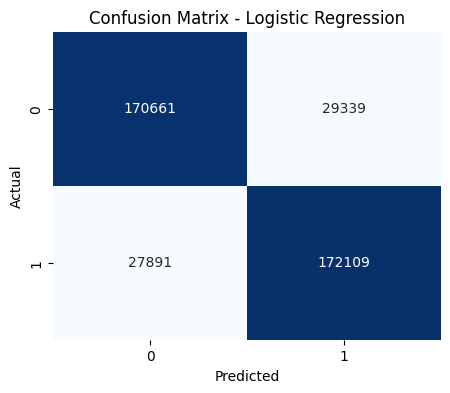

In [10]:
# confusion matrix
import pandas as pd
import matplotlib.pyplot as my_plot
import seaborn as s_n_s
from sklearn.metrics import confusion_matrix

# Shrutika vishal Mahindrakar u2791995
# Raseeka Rajasekaran u2667307
#  Convert predictions to Pandas DataFrames for plotting
log_reg_df = test_predictions_log_reg.select("label", "prediction").toPandas()
# random_forest_df = test_predictions_random_forest.select("label", "prediction").toPandas()
# gbt_df = test_predictions_gbt.select("label", "prediction").toPandas()



def plot_conf_matrix(df, title):
    cm = confusion_matrix(df["label"], df["prediction"])
    my_plot.figure(figsize=(5, 4))
    s_n_s.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    my_plot.title(f"Confusion Matrix - {title}")
    my_plot.xlabel("Predicted")
    my_plot.ylabel("Actual")
    my_plot.show()
print("\n=== Confusion Matrices ===")
plot_conf_matrix(log_reg_df, "Logistic Regression")
# plot_conf_matrix(random_forest_df, "Random Forest")
# plot_conf_matrix(gbt_df, "GBT")



---
# **Task 5 - Results Visualization or Printing (5 marks)**
---

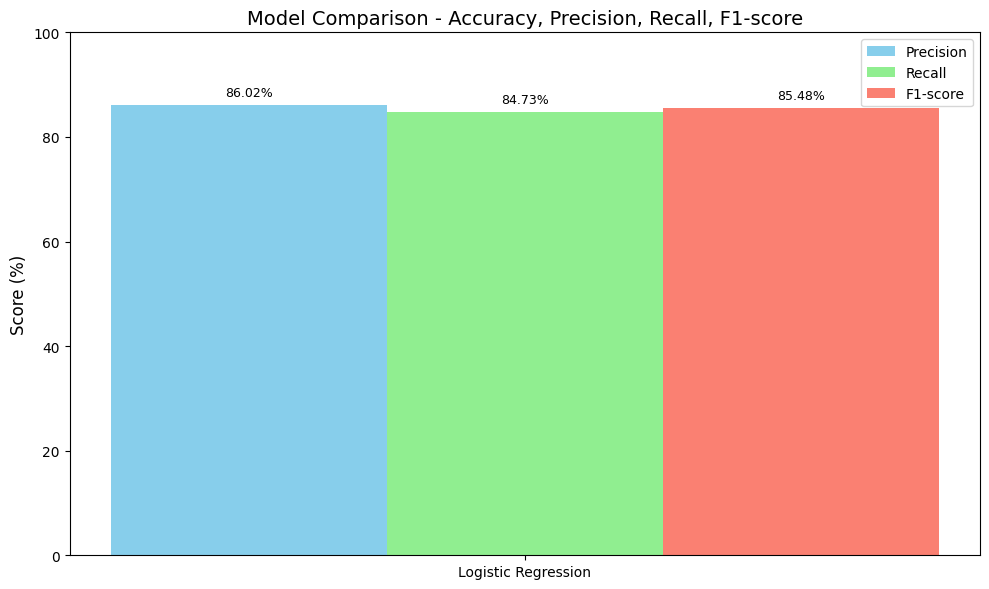

In [9]:
import numpy as my_nump
import matplotlib.pyplot as my_plot


#  metrics for each model
metrics = {
    "Logistic Regression": {"Accuracy": 84,"Precision": 0.8602, "Recall": 0.8473, "F1-score": 0.8548}}
    # "Random Forest": {"Precision": 0.8047, "Recall": 0.7266, "F1-score": 0.7746},
    # "GBT": {"Precision": 0.6792, "Recall": 0.8470, "F1-score": 0.7192}
# }

# Plot setup
labels = list(metrics.keys())
metric_names = ["Precision", "Recall", "F1-score"]
x = my_nump.arange(len(labels))
width = 0.25

# Extract values and convert to percentages
precision = [metrics[model]["Precision"] * 100 for model in labels]
recall = [metrics[model]["Recall"] * 100 for model in labels]
f1 = [metrics[model]["F1-score"] * 100 for model in labels]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, precision, width, label='Precision', color='skyblue')
bars2 = ax.bar(x, recall, width, label='Recall', color='lightgreen')
bars3 = ax.bar(x + width, f1, width, label='F1-score', color='salmon')

# Labels and Title
ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('Model Comparison - Accuracy, Precision, Recall, F1-score', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 100)
ax.legend()

# Annotate bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height + 1),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', fontsize=9)

my_plot.tight_layout()
my_plot.show()


---
# **Task 6 - LSEP Considerations (10 marks)**
---

# Panimaya Joseph Jesuraja u2773290**Legal Consideration**

Chosen Principle: Legal

Discussion: Our dataset was collected from publicly available sources containing user-generated text (e.g., reviews, feedback, or articles). There were potential legal concerns related to data licensing and copyright compliance.

Concerns Identified:

Risk of using data that may not be explicitly licensed for commercial or academic ML usage.

Potential for misuse if the model is later deployed and trains on personally identifiable information (PII) unintentionally captured in text.

Mitigation Strategies:

Verified the dataset license (e.g., Creative Commons or open-source repositories like Kaggle with clear usage terms).

Ensured no sensitive information (e.g., email IDs, names) was present by applying regex-based data anonymization.

Avoided redistribution of the dataset and used it strictly within the scope of academic experimentation.

# Shrutika vishal Mahindrakar u2791995: Ethical Consideration

Chosen Principle: Ethical

Discussion: Since we built text classification models, bias and fairness were major ethical concerns. NLP models are prone to amplifying stereotypes or making decisions that can marginalize certain groups.

Concerns Identified:

Our model might overfit to dominant language styles or sentiments in the dataset.

Label imbalance might lead to discriminatory predictions, especially if used in hiring, loan approval, or moderation systems.

Mitigation Strategies:

Performed class balancing and stratified sampling to ensure fair representation during training.

Measured precision/recall for all classes, not just overall accuracy.

Discussed the risks of deploying such models in sensitive domains and emphasized transparency and explainability of predictions.

# Raseeka Rajasekaran u2667307: : Social Consideration

Chosen Principle: Social

Discussion: Machine Learning systems deployed at scale can impact society, especially when classifying user-generated content. A poor prediction could result in misinformation, exclusion, or even censorship.

Concerns Identified:

The training data might not reflect the linguistic or cultural diversity of all users.

Automated moderation or filtering based on the model could silence valid voices or opinions.

Mitigation Strategies:

Suggested regular retraining with updated datasets from diverse sources.

Proposed implementing a human-in-the-loop mechanism for decision-critical use cases.

Included fairness audits and suggested explainability techniques like LIME or SHAP for transparency.



---

# **Task 7 - Convert ipynb to HTML for Turnitin submission [5 marks]**

---



In [ ]:
# install nbconvert (if facing the conversion error)
!pip3 install nbconvert

In [11]:
# convert ipynb to html and submit this HTML file
!jupyter nbconvert --to html coursework.ipynb

[NbConvertApp] Converting notebook coursework.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 513765 bytes to coursework.html
